In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

## Helper functions

In [2]:
def diff_percent(Dm,AAA):
    return 100*((Dm-AAA)/AAA)

print(diff_percent(105.0,100.0))

5.0


In [3]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [4]:
my_wilcox([1,2,3,4,6,7,2,352,3])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [38]:
def AAA_diff_plot(data1, data2, structure, metric, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    z_stat, p_val = wilcoxon(data1, data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    diff_pct = diff_percent(data1, data2)
    md        = np.mean(diff)                   # Mean of the difference
    md_pct    = np.mean(diff_pct)
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    # Uncomment for absoslute (Gy) 
    #plt.axhline(md,           color='red', linestyle='-')
    #plt.scatter(data1, diff, *args, **kwargs)
    #plt.ylabel('Dm - AAA dose difference Gy')
    #plt.title( str(np.round(md, decimals = 3)) + ' Gy mean difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    
    # % difference
    plt.axhline(md_pct,           color='red', linestyle='-')
    plt.scatter(data1, diff_pct, *args, **kwargs)
    plt.ylabel('Dm - AAA dose difference %')    
    plt.title( str(np.round(md_pct, decimals = 3)) + ' % mean difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    
    plt.xlabel('AAA Dose (Gy)')

In [6]:
def query_data(df, Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    return df[Col][(df['structure'] == structure) & (df['metric'] == metric)]

# Start analysis

In [7]:
HN_df = pd.read_csv('HN_df_clean_28_11.csv')  # read in the cleaned data

In [8]:
HN_df['Dm-AAA'] = HN_df['Dm'] - HN_df['AAA'] # get abs diff

In [9]:
HN_df['Dm-AAA%'] = diff_percent(HN_df['Dm'], HN_df['AAA'])

Exclude Case5 which has 54 Gy prescription

In [10]:
to_exclude = ['Case5', 'Case7']  # has prescription of 54 Gy
to_include = list(set(HN_df['Case'].unique()) - set(to_exclude))
HN_df = HN_df[HN_df['Case'].isin(to_include)]
HN_df['Case'].unique()

array(['Case1', 'Case2', 'Case3', 'Case4', 'Case6', 'Case8', 'Case9',
       'Case10'], dtype=object)

In [11]:
#HN_df = HN_df[['Case', 'structure', 'metric', 'Dm-AAA%']]  # keep only these columns
HN_df.head()

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
0,Case1,PTV2,D2%,65.392496,64.671451,-0.721045,-1.102642
1,Case1,PTV2,D5%,61.221910,60.574434,-0.647476,-1.057589
2,Case1,PTV2,D50%,56.935482,56.306392,-0.629090,-1.104918
3,Case1,PTV2,D95%,52.908380,53.783883,0.875503,1.654753
4,Case1,PTV2,D99%,38.261698,45.021250,6.759552,17.666628


Everything imported OK

## Get mean dose differences

In [12]:
mean_diff_table = HN_df.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA%') 

In [13]:
#metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']  # use limited subset
metrics_of_interest = mean_diff_table.columns                      # use all metrics

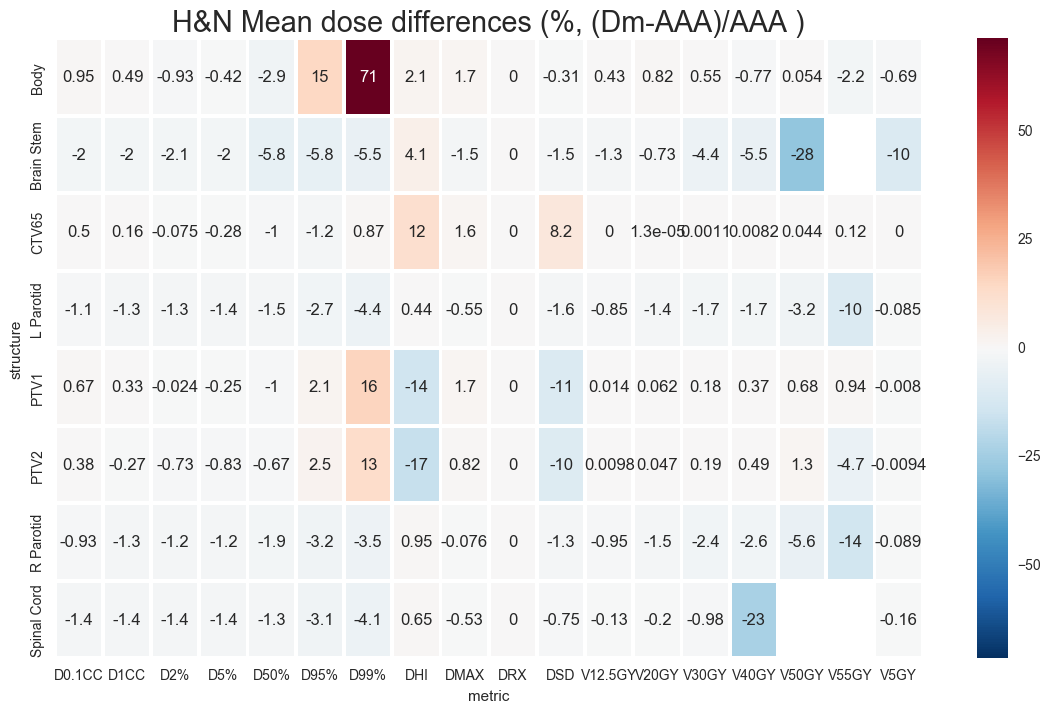

In [14]:
plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(mean_diff_table[metrics_of_interest], annot=True, linewidths=2.0, cbar=True)
ax1.set_title('H&N Mean dose differences (%, (Dm-AAA)/AAA )', size='xx-large')
plt.savefig('H&N Mean dose difference.png', dpi=200)

## Get wilcoxon p value of differences

In [15]:
metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']  # use limited subset
structures_of_interest = HN_df['structure'].unique()
structures_of_interest

array(['PTV2', 'PTV1', 'Body', 'R Parotid', 'L Parotid', 'Brain Stem',
       'Spinal Cord', 'CTV65'], dtype=object)

In [16]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [17]:
d = HN_df  # for convenience just copy

j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA%']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [18]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

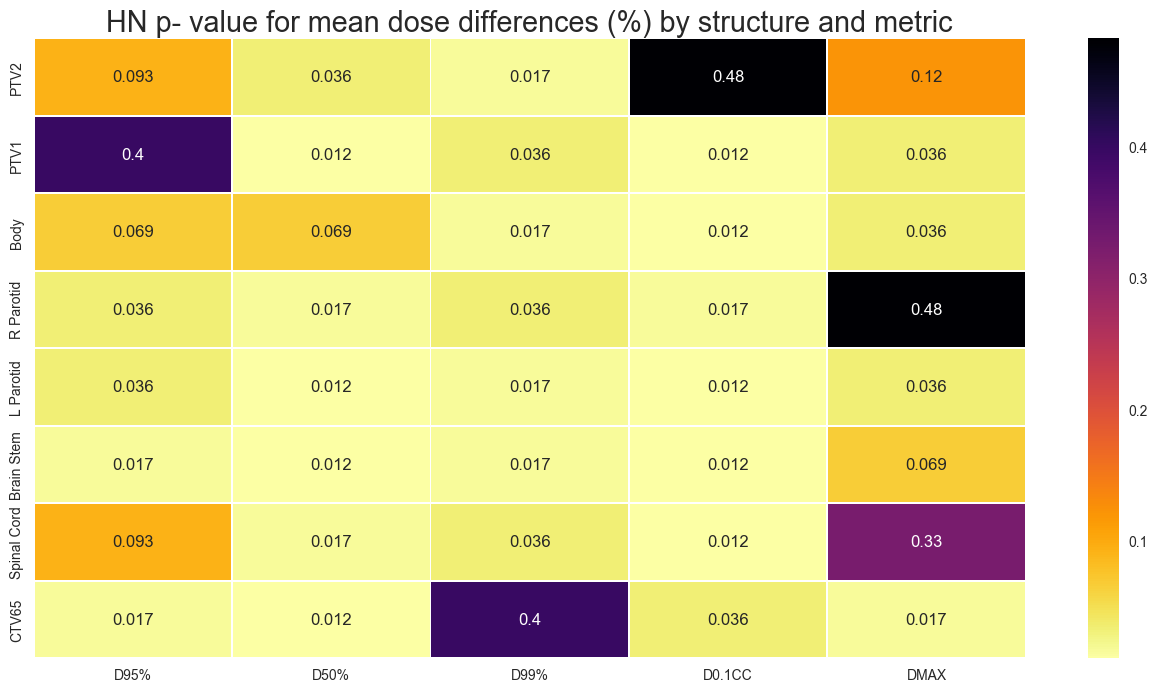

In [19]:
confidence = 1.0
plt.figure(figsize=(16, 8))
ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno_r')
ax2.set_title('HN p- value for mean dose differences (%) by structure and metric', size='xx-large')
plt.savefig('HN p value for mean dose differences.png', dpi=500)

In [20]:
sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

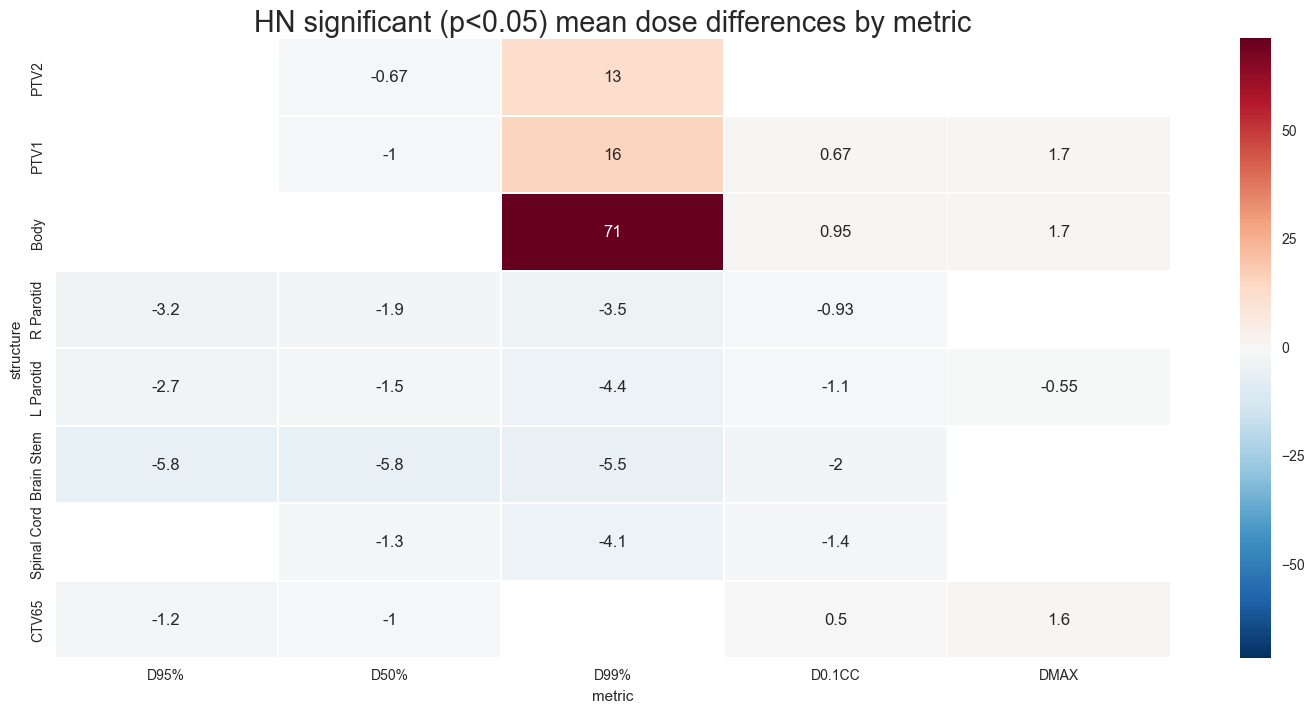

In [21]:
plt.figure(figsize=(18, 8)) 
data = sub_diff_table[wilcox_data_df<0.05]
mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True

ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('HN significant (p<0.05) mean dose differences by metric', size='xx-large')
plt.savefig('HN significant mean dose differences by metric.png', dpi=500)

# Investigate differences 

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


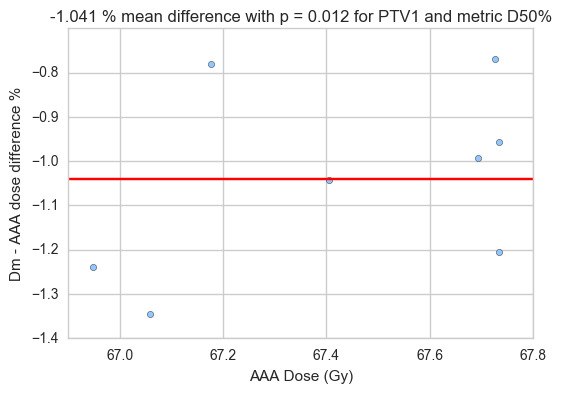

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
20,Case1,PTV1,D50%,68.559571,67.733731,-0.825840,-1.204558
164,Case2,PTV1,D50%,68.250510,67.725632,-0.524878,-0.769047
308,Case3,PTV1,D50%,68.372452,67.693337,-0.679114,-0.993257
452,Case4,PTV1,D50%,68.388653,67.734436,-0.654217,-0.956616
740,Case6,PTV1,D50%,67.787586,66.948429,-0.839157,-1.237922
1028,Case8,PTV1,D50%,68.116240,67.405729,-0.710511,-1.043086
1262,Case9,PTV1,D50%,67.705087,67.176668,-0.528418,-0.780471
1406,Case10,PTV1,D50%,67.973479,67.059061,-0.914418,-1.345257


In [39]:
structure = 'PTV1'
metric = 'D50%'
plt.figure(figsize=(6, 4)) 
#bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
AAA_diff_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
HN_df[(HN_df['structure'] == structure) & (HN_df['metric'] == metric)]

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


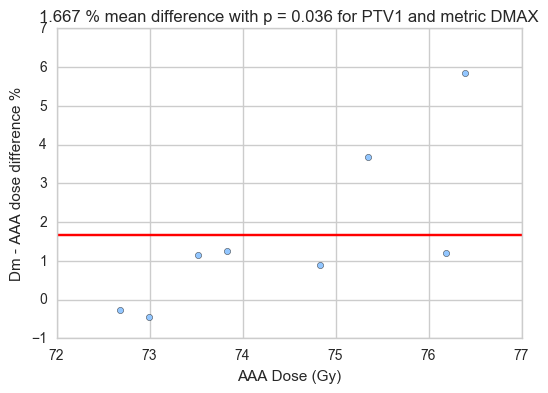

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
25,Case1,PTV1,DMAX,73.32000,72.99500,-0.32500,-0.443262
169,Case2,PTV1,DMAX,75.28158,76.19172,0.91014,1.208981
313,Case3,PTV1,DMAX,74.16500,74.83000,0.66500,0.896649
457,Case4,PTV1,DMAX,72.92000,73.83500,0.91500,1.254800
745,Case6,PTV1,DMAX,72.16110,76.38675,4.22565,5.855856
1033,Case8,PTV1,DMAX,72.68118,73.52631,0.84513,1.162791
1267,Case9,PTV1,DMAX,72.68118,75.34659,2.66541,3.667263
1411,Case10,PTV1,DMAX,72.87621,72.68118,-0.19503,-0.267618


In [40]:
structure = 'PTV1'
metric = 'DMAX'
plt.figure(figsize=(6, 4)) 
AAA_diff_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
#bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
HN_df[(HN_df['structure'] == structure) & (HN_df['metric'] == metric)]